# Milwaukee Network: Scenario Evaluation with CBA and MCA (car-only)

This notebook evaluates transport infrastructure scenarios for Milwaukee using:
- Cost-Benefit Analysis (CBA)
- Multi-Criteria Analysis (MCA)

**Scenarios Tested:**
1. **Baseline**: Current network condition (reference scenario)
2. **Capacity +20%**: Increase road capacity by 20% on all links (€5M CAPEX, €150k/year OPEX)
3. **Adaptive Traffic Signals**: Smart signal management system with 12% delay reduction and 8% capacity improvement (€800k CAPEX, €50k/year OPEX)
4. **Low Emission Zone (LEZ)**: City-center restriction of high-emission vehicles with 10% demand reduction (€700k CAPEX, €250k/year OPEX)

## Setup and Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries loaded successfully!")

Libraries loaded successfully!


## Configuration Parameters

In [2]:
# Directories
BASE_DIR = Path('..')
DATA_DIR = BASE_DIR / 'data_preprocessed'
RESULTS_DIR = BASE_DIR / 'results'
BASELINE_DIR = RESULTS_DIR / 'baseline'

# CBA Parameters
DISCOUNT_RATE = 0.04  # 4% annual discount rate
EVALUATION_HORIZON = 20  # years
VALUE_OF_TIME = 15.0  # €/hour
CO2_PRICE = 100  # €/tonne
EMISSION_FACTOR_KG_PER_KM = 0.2  # kg CO2/km for cars
AVG_TRIP_LENGTH_KM = 8.0  # Average trip length
ANNUALIZATION_FACTOR = 250  # Working days per year (for peak hour to annual conversion)

CAPEX_CAPACITY = 5_000_000  # $5M for capacity expansion
OPEX_CAPACITY = 150_000  # $150k/year maintenance (3% of CAPEX)
CAPEX_SIGNALS = 800_000  # $800k for adaptive traffic signal system
OPEX_SIGNALS = 50_000  # $50k/year maintenance and operation (6% of CAPEX)
CAPEX_LEZ = 700_000  # $700k for LEZ enforcement (cameras, ANPR, monitoring)
OPEX_LEZ = 250_000  # $250k/year for operation and enforcement

# Scenario parameters
CAPACITY_INCREASE = 0.20  # 20% capacity increase
SIGNALS_DELAY_REDUCTION = 0.12  # 12% delay reduction from adaptive signals
SIGNALS_CAPACITY_IMPROVEMENT = 0.08  # 8% effective capacity increase from better flow
LEZ_DEMAND_REDUCTION = 0.10  # 10% demand reduction from LEZ restriction
LEZ_TOP_OD_FRACTION = 0.30  # Apply to top 30% of OD pairs by volume (city center)
LEZ_EMISSION_REDUCTION_FACTOR = 1.0  # Emission factor multiplier for removed trips (1.0 = same as average)

# MCA weights
MCA_WEIGHTS = {
    'npv': 0.40,
    'bcr': 0.30,
    'time_savings': 0.20,
    'co2_reduction': 0.10
}

print(f"CO2 price: €{CO2_PRICE}/tonne")
print(f"Discount rate: {DISCOUNT_RATE:.1%}")
print(f"Evaluation horizon: {EVALUATION_HORIZON} years")
print(f"Value of time: €{VALUE_OF_TIME}/hour")

CO2 price: €100/tonne
Discount rate: 4.0%
Evaluation horizon: 20 years
Value of time: €15.0/hour


## Data Loading

In [3]:
# Load network data (prefer baseline results if available)
def load_with_fallback(stem: str, fallback_path: str):
    """Load data from baseline results or fallback to original data."""
    baseline_path = BASELINE_DIR / f"{stem}.csv"
    if baseline_path.exists():
        print(f"Loading {stem} from baseline results")
        return pd.read_csv(baseline_path)
    print(f"  Loading {stem} from {fallback_path}")
    return pd.read_csv(fallback_path)

# Load core datasets
nodes_df = load_with_fallback('nodes', DATA_DIR / 'node.csv')
links_df = load_with_fallback('links', DATA_DIR / 'link.csv')
demand_df = load_with_fallback('demand', DATA_DIR / 'demand.csv')

# Load link performance with fallback
link_perf_baseline = BASELINE_DIR / 'link_performance.csv'
link_perf_fallback = DATA_DIR / 'link_performance.csv'
if link_perf_baseline.exists():
    link_performance = pd.read_csv(link_perf_baseline)
    print("Loaded link performance from baseline")
elif link_perf_fallback.exists():
    link_performance = pd.read_csv(link_perf_fallback)
    print(f"  Loading link performance from {link_perf_fallback}")
else:
    link_performance = None
    print("  Link performance not found; will synthesize")

print(f"\nData summary:")
print(f"  Nodes: {len(nodes_df):,}")
print(f"  Links: {len(links_df):,}")
print(f"  OD pairs: {len(demand_df):,}")
print(f"  Total demand: {demand_df['volume'].sum():,.0f} trips")

Loading nodes from baseline results
Loading links from baseline results
Loading demand from baseline results
Loaded link performance from baseline

Data summary:
  Nodes: 8,521
  Links: 30,747
  OD pairs: 30,422
  Total demand: 163,700 trips


## Helper Functions

In [4]:
def build_graph(links: pd.DataFrame) -> tuple[nx.DiGraph, dict]:
    """Build NetworkX graph from link dataframe."""
    G = nx.DiGraph()
    for _, r in links.iterrows():
        G.add_edge(r['from_node_id'], r['to_node_id'], 
                   length=r.get('length', 1.0),
                   link_id=r['link_id'])
    edge_to_link = {(r['from_node_id'], r['to_node_id']): r['link_id'] 
                    for _, r in links.iterrows()}
    return G, edge_to_link


def apply_signal_optimization(lp: pd.DataFrame, delay_reduction: float, capacity_improvement: float) -> pd.DataFrame:
    """Apply adaptive signal optimization effects: reduced delays and improved effective capacity."""
    df = lp.copy()
    # Effective capacity increase from better coordination
    df['capacity'] *= (1 + capacity_improvement)
    # Smoother flow reduces effective congestion
    df['volume'] *= (1 - delay_reduction * 0.3)
    df['vc_ratio'] = df['volume'] / df['capacity'].replace(0, np.nan)
    return df


def ensure_link_perf(lp: pd.DataFrame | None, links: pd.DataFrame) -> pd.DataFrame:
    """Ensure link performance dataframe has required columns."""
    if lp is None:
        df = links[['link_id', 'from_node_id', 'to_node_id', 'capacity']].copy()
        df['volume'] = df['capacity'] * 0.6  # synthetic baseline
    else:
        df = lp.copy()
        if 'capacity' not in df.columns and 'link_capacity' in df.columns:
            df = df.rename(columns={'link_capacity': 'capacity'})
        if 'volume' not in df.columns:
            for cand in ['mod_vol_auto', 'ref_volume', 'base_demand_volume']:
                if cand in df.columns:
                    df['volume'] = df[cand]
                    break
            if 'volume' not in df.columns:
                df['volume'] = df['capacity'] * 0.6
        df = df[['link_id', 'from_node_id', 'to_node_id', 'capacity', 'volume']].copy()
    df['vc_ratio'] = df['volume'] / df['capacity'].replace(0, np.nan)
    return df


def annuity_factor(rate: float, n_years: int) -> float:
    """Calculate present value annuity factor."""
    return (1 - (1 + rate)**(-n_years)) / rate


def travel_time_from_vc(mean_vc: float, free_flow_time: float = 10.0, alpha: float = 0.15, beta: float = 4.0) -> float:
    """
    Calculate travel time using BPR (Bureau of Public Roads) function.
    
    Travel time = free_flow_time * [1 + alpha * (V/C)^beta]
    
    Parameters:
    - free_flow_time: baseline travel time in minutes (default: 10 min)
    - alpha: calibration parameter (default: 0.15)
    - beta: congestion sensitivity parameter (default: 4.0)
    
    Returns travel time in minutes.
    """
    return free_flow_time * (1 + alpha * (mean_vc ** beta))


def gini(x):
    """
    Calculate Gini coefficient with proper edge case handling.
    Returns value in [0, 1] where 0 = perfect equality, 1 = maximum inequality.
    Uses the correct discrete Gini formula.
    """
    # Remove NaN and negative values
    clean_x = x.dropna()
    clean_x = clean_x[clean_x >= 0]
    
    if len(clean_x) == 0 or clean_x.sum() == 0:
        return 0.0  # No inequality if no data or all zeros
    
    sorted_x = np.sort(clean_x)
    n = len(sorted_x)
    
    # Correct discrete Gini formula:
    # G = (2 * sum(i * x_i)) / (n * sum(x_i)) - (n + 1) / n
    # where i goes from 1 to n
    index = np.arange(1, n + 1)
    gini_val = (2.0 * np.sum(index * sorted_x)) / (n * np.sum(sorted_x)) - (n + 1) / n
    
    # Ensure result is in valid range [0, 1]
    return max(0.0, min(1.0, gini_val))


print("Helper functions defined.")

Helper functions defined.


## Baseline Scenario Analysis

In [5]:
# Prepare baseline link performance
lp_base = ensure_link_perf(link_performance, links_df)

# Build graph and find top-demand OD
G, edge_lookup = build_graph(links_df)
top_od = demand_df.nlargest(1, 'volume').iloc[0]

try:
    path_nodes = nx.shortest_path(G, source=top_od['o_zone_id'], 
                                  target=top_od['d_zone_id'], weight='length')
    edges_on_path = list(zip(path_nodes[:-1], path_nodes[1:]))
except nx.NetworkXNoPath:
    path_nodes = []
    edges_on_path = []

# Baseline metrics
baseline_metrics = {
    'total_demand': demand_df['volume'].sum(),
    'total_capacity': links_df['capacity'].sum(),
    'mean_vc': lp_base['vc_ratio'].mean(),
    'median_vc': lp_base['vc_ratio'].median(),
    'max_vc': lp_base['vc_ratio'].max(),
    'pct_congested': (lp_base['vc_ratio'] > 1.0).mean() * 100,
    'total_volume': lp_base['volume'].sum(),
}

print("=" * 70)
print("BASELINE SCENARIO METRICS")
print("=" * 70)
print(f"Total demand: {baseline_metrics['total_demand']:,.0f} trips")
print(f"Total capacity: {baseline_metrics['total_capacity']:,.0f} veh/h")
print(f"Mean V/C ratio: {baseline_metrics['mean_vc']:.3f}")
print(f"Max V/C ratio: {baseline_metrics['max_vc']:.3f}")
print(f"Congested links (V/C>1): {baseline_metrics['pct_congested']:.1f}%")
print(f"\nTop-demand OD: {top_od['o_zone_id']} → {top_od['d_zone_id']}")
print(f"Volume: {top_od['volume']:,.0f} trips")
print(f"Path nodes: {len(path_nodes)}, Path edges: {len(edges_on_path)}")

BASELINE SCENARIO METRICS
Total demand: 163,700 trips
Total capacity: 1,679,561,026 veh/h
Mean V/C ratio: 0.222
Max V/C ratio: 12.484
Congested links (V/C>1): 6.1%

Top-demand OD: 7 → 67
Volume: 202 trips
Path nodes: 40, Path edges: 39


## Scenario Definition and Simulation

In [6]:
# Scenario 1: Capacity +20%
links_s1 = links_df.copy()
links_s1['capacity'] *= (1 + CAPACITY_INCREASE)

lp_s1 = lp_base.copy()
lp_s1['capacity'] *= (1 + CAPACITY_INCREASE)
lp_s1['vc_ratio'] = lp_s1['volume'] / lp_s1['capacity'].replace(0, np.nan)

demand_s1 = demand_df.copy()

# Scenario 2: Adaptive Traffic Signal Management
links_s2 = links_df.copy()
# No physical capacity change, but improved flow
links_s2['capacity'] *= (1 + SIGNALS_CAPACITY_IMPROVEMENT)

demand_s2 = demand_df.copy()  # Demand unchanged

lp_s2 = apply_signal_optimization(lp_base, SIGNALS_DELAY_REDUCTION, SIGNALS_CAPACITY_IMPROVEMENT)

# Scenario 3: Low Emission Zone (LEZ)
# Identify top OD pairs for city center zone (by volume)
demand_sorted = demand_df.sort_values('volume', ascending=False)
n_lez_ods = int(len(demand_df) * LEZ_TOP_OD_FRACTION)
lez_od_indices = demand_sorted.head(n_lez_ods).index

demand_s3 = demand_df.copy()
# Apply LEZ restriction: remove 10% of trips (emission factor multiplier configurable)
demand_s3.loc[lez_od_indices, 'volume'] *= (1 - LEZ_DEMAND_REDUCTION)

# Calculate volume reduction for links (approximate distribution)
total_volume_reduction = (demand_df.loc[lez_od_indices, 'volume'].sum() * LEZ_DEMAND_REDUCTION)
avg_reduction_per_link = total_volume_reduction / len(links_df)

lp_s3 = lp_base.copy()
lp_s3['volume'] = np.maximum(lp_s3['volume'] - avg_reduction_per_link, 0)
lp_s3['vc_ratio'] = lp_s3['volume'] / lp_s3['capacity'].replace(0, np.nan)

links_s3 = links_df.copy()  # No capacity change

print("Scenarios defined:")
print(f"  S1: Capacity +{CAPACITY_INCREASE:.0%} on all links")
print(f"  S2: Adaptive Signals - {SIGNALS_DELAY_REDUCTION:.0%} delay reduction, {SIGNALS_CAPACITY_IMPROVEMENT:.0%} capacity improvement")
print(f"  S3: Low Emission Zone - {LEZ_DEMAND_REDUCTION:.0%} demand reduction on top {LEZ_TOP_OD_FRACTION:.0%} OD pairs")
print(f"      Emission factor multiplier: {LEZ_EMISSION_REDUCTION_FACTOR:.1f}× (set to 1.0 for average emitters)")
print(f"      City center OD pairs: {n_lez_ods:,}")

Scenarios defined:
  S1: Capacity +20% on all links
  S2: Adaptive Signals - 12% delay reduction, 8% capacity improvement
  S3: Low Emission Zone - 10% demand reduction on top 30% OD pairs
      Emission factor multiplier: 1.0× (set to 1.0 for average emitters)
      City center OD pairs: 9,126


## KPI Comparison Across Scenarios


SCENARIO KPI COMPARISON
         Scenario  Total Demand  Total Capacity  Mean V/C   Max V/C  % Congested
         Baseline      163700.0    1.679561e+09  0.222433 12.484286     6.094904
    Capacity +20%      163700.0    2.015473e+09  0.185361 10.403571     4.751683
 Adaptive Signals      163700.0    1.813926e+09  0.198542 11.143381     5.213517
Low Emission Zone      151373.4    1.679561e+09  0.222358 12.483999     6.094904


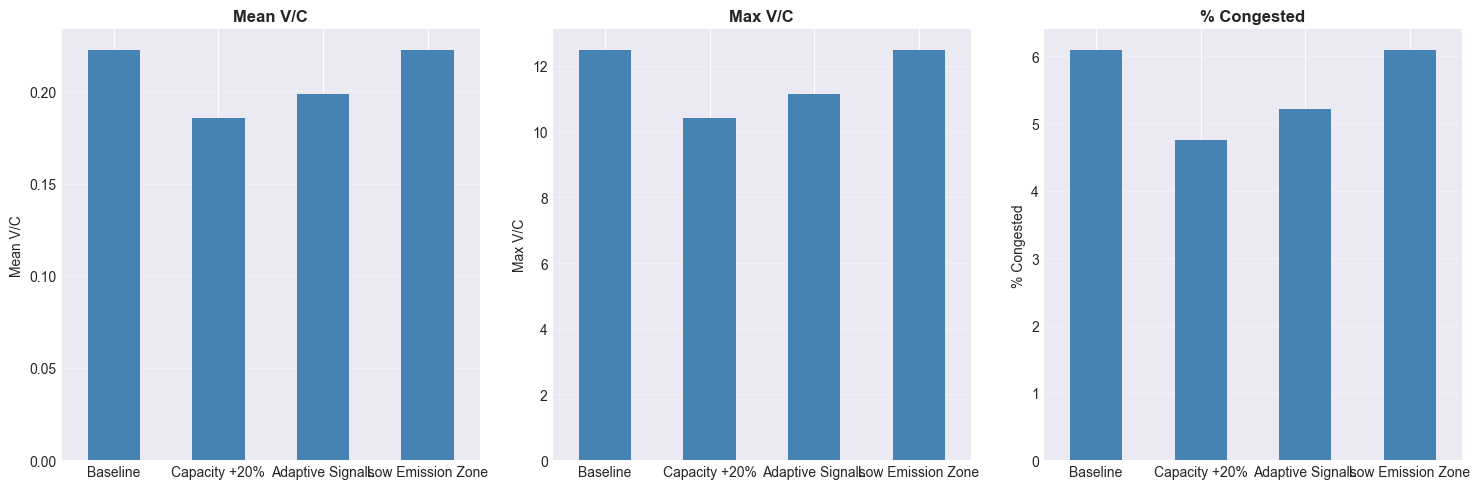

In [7]:
def calc_scenario_metrics(name: str, lp: pd.DataFrame, demand: pd.DataFrame, links: pd.DataFrame) -> dict:
    return {
        'Scenario': name,
        'Total Demand': demand['volume'].sum(),
        'Total Capacity': links['capacity'].sum(),
        'Mean V/C': lp['vc_ratio'].mean(),
        'Max V/C': lp['vc_ratio'].max(),
        '% Congested': (lp['vc_ratio'] > 1.0).mean() * 100,
    }

scenarios_kpi = [
    calc_scenario_metrics('Baseline', lp_base, demand_df, links_df),
    calc_scenario_metrics('Capacity +20%', lp_s1, demand_s1, links_s1),
    calc_scenario_metrics('Adaptive Signals', lp_s2, demand_s2, links_s2),
    calc_scenario_metrics('Low Emission Zone', lp_s3, demand_s3, links_s3),
]

kpi_df = pd.DataFrame(scenarios_kpi)
print("\n" + "=" * 70)
print("SCENARIO KPI COMPARISON")
print("=" * 70)
print(kpi_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
metrics_to_plot = ['Mean V/C', 'Max V/C', '% Congested']

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    kpi_df.plot(x='Scenario', y=metric, kind='bar', ax=ax, legend=False, color='steelblue')
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.set_ylabel(metric)
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=0)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Scenario Performance Analysis

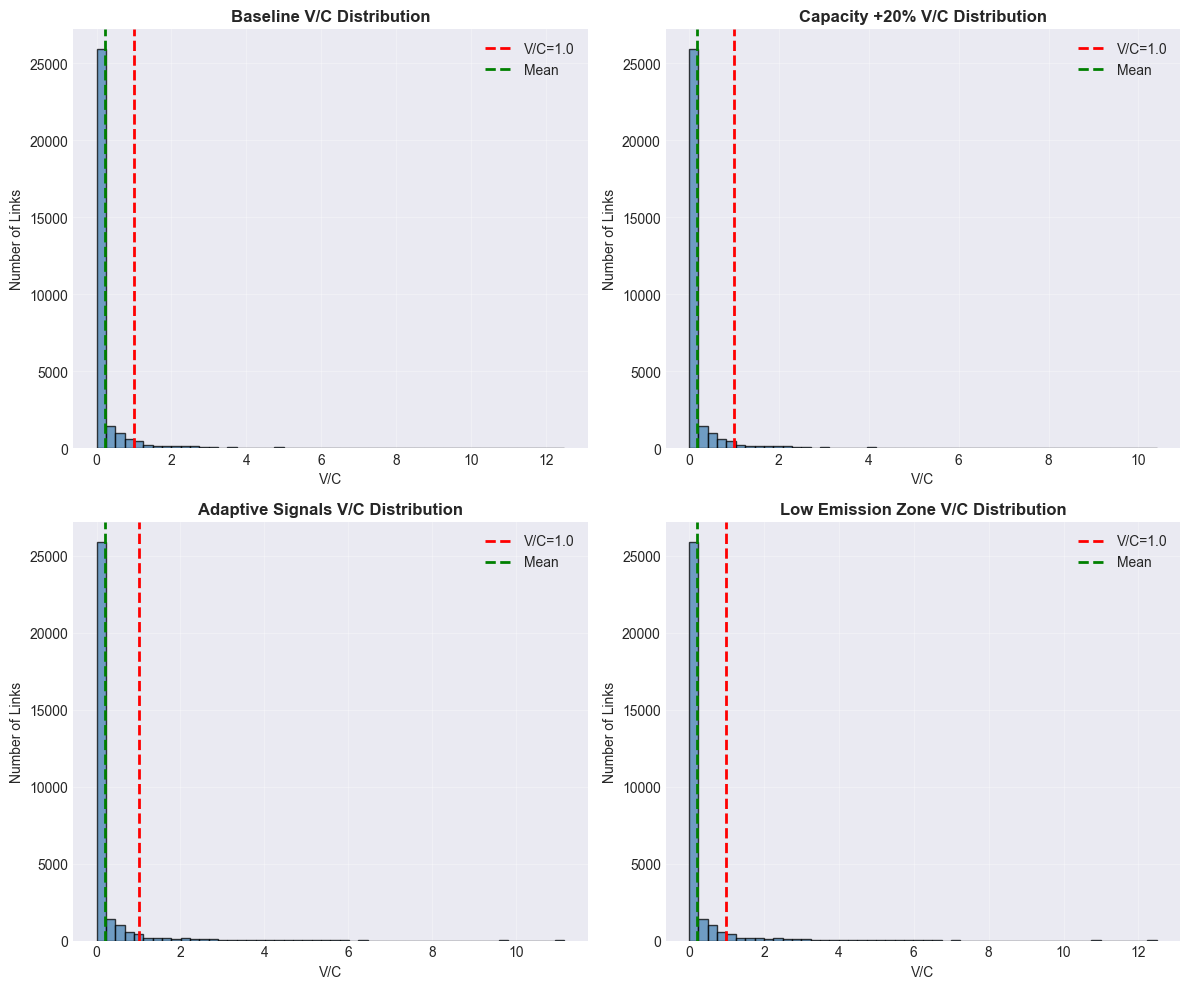

V/C DISTRIBUTION SUMMARY
Baseline            : Mean V/C = 0.222, Max V/C = 12.484, % Congested = 6.1%
Capacity +20%       : Mean V/C = 0.185, Max V/C = 10.404, % Congested = 4.8%
Adaptive Signals    : Mean V/C = 0.199, Max V/C = 11.143, % Congested = 5.2%
Low Emission Zone   : Mean V/C = 0.222, Max V/C = 12.484, % Congested = 6.1%


In [8]:
# V/C distribution plots by scenario
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

scenario_lp = {
    'Baseline': lp_base.copy(),
    'Capacity +20%': lp_s1.copy(),
    'Adaptive Signals': lp_s2.copy(),
    'Low Emission Zone': lp_s3.copy(),
}

for ax, (scenario_name, lp_df) in zip(axes, scenario_lp.items()):
    if 'vc_ratio' not in lp_df.columns:
        lp_df['vc_ratio'] = lp_df['volume'] / lp_df['capacity'].replace(0, np.nan)
    ax.hist(lp_df['vc_ratio'], bins=50, color='steelblue', edgecolor='black', alpha=0.75)
    ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='V/C=1.0')
    ax.axvline(lp_df['vc_ratio'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')
    ax.set_title(f"{scenario_name} V/C Distribution", fontweight='bold')
    ax.set_xlabel('V/C')
    ax.set_ylabel('Number of Links')
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.show()

print("=" * 70)
print("V/C DISTRIBUTION SUMMARY")
print("=" * 70)
for name, lp_df in scenario_lp.items():
    if 'vc_ratio' not in lp_df.columns:
        lp_df['vc_ratio'] = lp_df['volume'] / lp_df['capacity'].replace(0, np.nan)
    pct_over_1 = (lp_df['vc_ratio'] > 1.0).mean() * 100
    print(f"{name:20s}: Mean V/C = {lp_df['vc_ratio'].mean():.3f}, "
          f"Max V/C = {lp_df['vc_ratio'].max():.3f}, "
          f"% Congested = {pct_over_1:.1f}%")

## Part 1: Accessibility and Equity Analysis

This section analyzes spatial equity in terms of accessibility distribution across zones.

In [9]:
# Calculate accessibility metrics for each scenario
# We'll approximate accessibility changes based on demand and congestion patterns

def calculate_accessibility_equity(demand: pd.DataFrame, lp: pd.DataFrame, scenario_name: str) -> dict:
    """
    Calculate accessibility equity metrics for a scenario.
    
    Approximates accessibility by zone based on:
    - Total outbound demand (origin accessibility)
    - Total inbound demand (destination accessibility)
    - Mean V/C on network (proxy for travel impedance)
    """
    # Origin accessibility: aggregate outbound demand by origin zone
    origin_totals = demand.groupby('o_zone_id')['volume'].agg(['sum', 'count']).reset_index()
    origin_totals.columns = ['zone_id', 'total_volume', 'num_destinations']
    
    # Destination accessibility: aggregate inbound demand by destination zone
    dest_totals = demand.groupby('d_zone_id')['volume'].agg(['sum', 'count']).reset_index()
    dest_totals.columns = ['zone_id', 'total_volume', 'num_origins']
    
    # Network impedance proxy (higher V/C = worse accessibility)
    mean_vc = lp['vc_ratio'].mean()
    impedance_factor = 1 / (1 + mean_vc)  # Lower when more congested
    
    # Adjusted accessibility (volume weighted by impedance)
    origin_totals['adjusted_accessibility'] = origin_totals['total_volume'] * impedance_factor
    dest_totals['adjusted_accessibility'] = dest_totals['total_volume'] * impedance_factor
    
    # Calculate Gini coefficients
    gini_metrics = {
        'scenario': scenario_name,
        'gini_origin_volume': gini(origin_totals['total_volume']),
        'gini_origin_destinations': gini(origin_totals['num_destinations']),
        'gini_origin_accessibility': gini(origin_totals['adjusted_accessibility']),
        'gini_dest_volume': gini(dest_totals['total_volume']),
        'gini_dest_origins': gini(dest_totals['num_origins']),
        'gini_dest_accessibility': gini(dest_totals['adjusted_accessibility']),
        'mean_vc': mean_vc,
        'impedance_factor': impedance_factor,
    }
    
    return gini_metrics, origin_totals, dest_totals


# Calculate for all scenarios
scenario_accessibility = {}
accessibility_gini_results = []

scenarios_data = {
    'Baseline': (demand_df, lp_base),
    'Capacity +20%': (demand_s1, lp_s1),
    'Adaptive Signals': (demand_s2, lp_s2),
    'Low Emission Zone': (demand_s3, lp_s3),
}

for name, (demand, lp) in scenarios_data.items():
    metrics, origin_df, dest_df = calculate_accessibility_equity(demand, lp, name)
    scenario_accessibility[name] = {'metrics': metrics, 'origins': origin_df, 'destinations': dest_df}
    accessibility_gini_results.append(metrics)

# Create comparison dataframe
access_gini_df = pd.DataFrame(accessibility_gini_results)

print("=" * 80)
print("SCENARIO-BASED ACCESSIBILITY EQUITY ANALYSIS")
print("=" * 80)
print("\nGini Coefficients by Scenario (0=perfect equality, 1=maximum inequality):")
print("-" * 80)

# Display with formatted output
display_cols = ['scenario', 'gini_origin_volume', 'gini_origin_destinations', 
                'gini_origin_accessibility', 'gini_dest_volume', 'gini_dest_origins',
                'gini_dest_accessibility', 'mean_vc']

print(access_gini_df[display_cols].to_string(index=False))

print("\n" + "=" * 80)
print("INTERPRETATION:")
print("=" * 80)

# Compare to baseline
baseline_metrics = access_gini_df[access_gini_df['scenario'] == 'Baseline'].iloc[0]

for _, row in access_gini_df[access_gini_df['scenario'] != 'Baseline'].iterrows():
    print(f"\n{row['scenario']}:")
    
    # Origin accessibility change
    origin_change = row['gini_origin_accessibility'] - baseline_metrics['gini_origin_accessibility']
    print(f"  Origin accessibility Gini: {row['gini_origin_accessibility']:.4f} "
          f"({'+' if origin_change > 0 else ''}{origin_change:.4f} vs baseline)")
    
    # Destination accessibility change
    dest_change = row['gini_dest_accessibility'] - baseline_metrics['gini_dest_accessibility']
    print(f"  Dest accessibility Gini:   {row['gini_dest_accessibility']:.4f} "
          f"({'+' if dest_change > 0 else ''}{dest_change:.4f} vs baseline)")
    
    # Interpretation
    if abs(origin_change) < 0.01 and abs(dest_change) < 0.01:
        equity_impact = "Minimal equity impact"
    elif origin_change < -0.01 or dest_change < -0.01:
        equity_impact = "IMPROVES equity (lower Gini = more equal)"
    else:
        equity_impact = "WORSENS equity (higher Gini = less equal)"
    
    print(f"  → {equity_impact}")

print("\n" + "=" * 80)

SCENARIO-BASED ACCESSIBILITY EQUITY ANALYSIS

Gini Coefficients by Scenario (0=perfect equality, 1=maximum inequality):
--------------------------------------------------------------------------------
         scenario  gini_origin_volume  gini_origin_destinations  gini_origin_accessibility  gini_dest_volume  gini_dest_origins  gini_dest_accessibility  mean_vc
         Baseline            0.220233                  0.095582                   0.220233          0.646523            0.26428                 0.646523 0.222433
    Capacity +20%            0.220233                  0.095582                   0.220233          0.646523            0.26428                 0.646523 0.185361
 Adaptive Signals            0.220233                  0.095582                   0.220233          0.646523            0.26428                 0.646523 0.198542
Low Emission Zone            0.215679                  0.095582                   0.215679          0.633498            0.26428                 0.63349

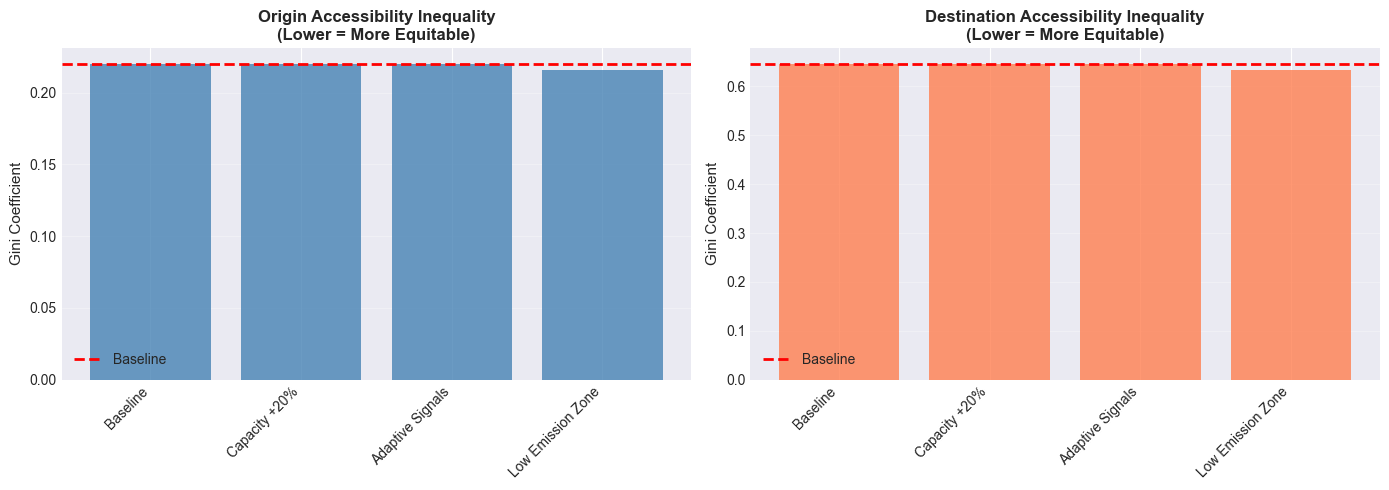

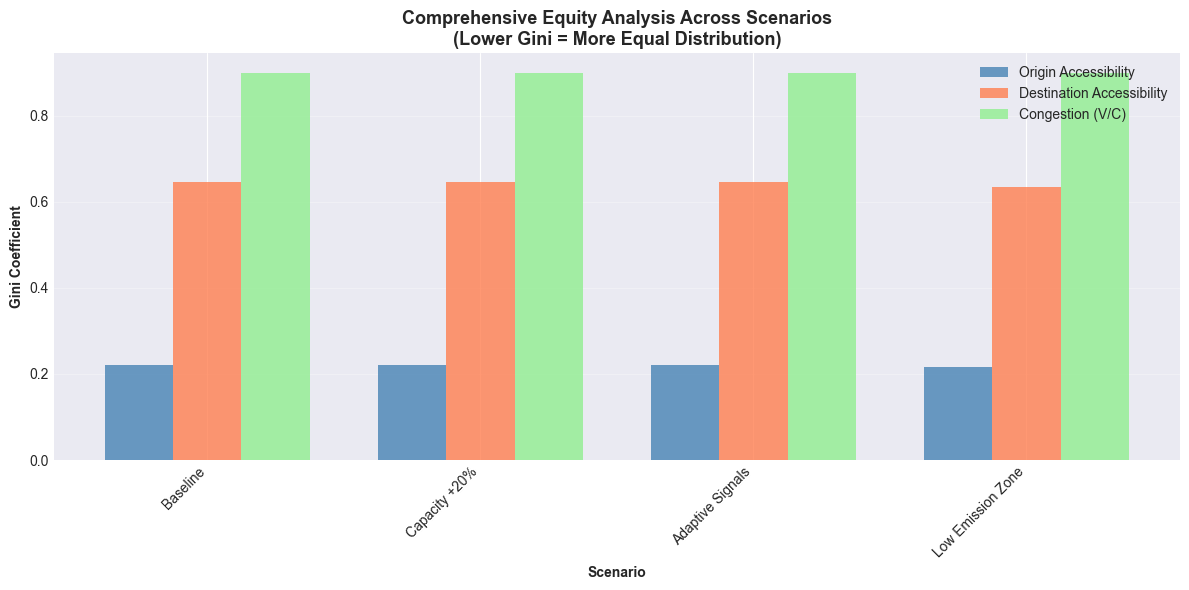

In [10]:
# Visualize accessibility equity across scenarios

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Origin Accessibility Gini
ax1 = axes[0]
x_pos = np.arange(len(access_gini_df))
ax1.bar(x_pos, access_gini_df['gini_origin_accessibility'], color='steelblue', alpha=0.8)
ax1.axhline(baseline_metrics['gini_origin_accessibility'], color='red', 
            linestyle='--', linewidth=2, label='Baseline')
ax1.set_ylabel('Gini Coefficient', fontsize=11)
ax1.set_xlabel('')
ax1.set_title('Origin Accessibility Inequality\n(Lower = More Equitable)', fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(access_gini_df['scenario'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.legend()

# Plot 2: Destination Accessibility Gini
ax2 = axes[1]
ax2.bar(x_pos, access_gini_df['gini_dest_accessibility'], color='coral', alpha=0.8)
ax2.axhline(baseline_metrics['gini_dest_accessibility'], color='red', 
            linestyle='--', linewidth=2, label='Baseline')
ax2.set_ylabel('Gini Coefficient', fontsize=11)
ax2.set_xlabel('')
ax2.set_title('Destination Accessibility Inequality\n(Lower = More Equitable)', fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(access_gini_df['scenario'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend()

plt.tight_layout()
plt.show()

# Calculate V/C Gini coefficients for combined visualization
vc_gini_values = [
    gini(lp_base['volume'] / lp_base['capacity'].replace(0, np.nan)),
    gini(lp_s1['volume'] / lp_s1['capacity'].replace(0, np.nan)),
    gini(lp_s2['volume'] / lp_s2['capacity'].replace(0, np.nan)),
    gini(lp_s3['volume'] / lp_s3['capacity'].replace(0, np.nan))
]

# Additional visualization: Combined equity metrics
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(access_gini_df))
width = 0.25

bars1 = ax.bar(x - width, access_gini_df['gini_origin_accessibility'], width, 
               label='Origin Accessibility', color='steelblue', alpha=0.8)
bars2 = ax.bar(x, access_gini_df['gini_dest_accessibility'], width, 
               label='Destination Accessibility', color='coral', alpha=0.8)
bars3 = ax.bar(x + width, vc_gini_values, width, 
               label='Congestion (V/C)', color='lightgreen', alpha=0.8)

ax.set_xlabel('Scenario', fontweight='bold')
ax.set_ylabel('Gini Coefficient', fontweight='bold')
ax.set_title('Comprehensive Equity Analysis Across Scenarios\n(Lower Gini = More Equal Distribution)', 
             fontweight='bold', fontsize=13)
ax.set_xticks(x)
ax.set_xticklabels(access_gini_df['scenario'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Part 2: Cost-Benefit Analysis (CBA)

This section evaluates the economic viability of each scenario using:
- Time savings valuation (based on BPR travel time function)
- CO2 emissions reduction benefits
- CAPEX and OPEX costs
- Net Present Value (NPV) and Benefit-Cost Ratio (BCR)

In [11]:
# Annual trips for scaling
ANNUAL_TRIPS = demand_df['volume'].sum() * ANNUALIZATION_FACTOR
pv_factor = annuity_factor(DISCOUNT_RATE, EVALUATION_HORIZON)

# Extract mean V/C for each scenario
vc_baseline = kpi_df[kpi_df['Scenario'] == 'Baseline']['Mean V/C'].values[0]
vc_cap = kpi_df[kpi_df['Scenario'] == 'Capacity +20%']['Mean V/C'].values[0]
vc_signals = kpi_df[kpi_df['Scenario'] == 'Adaptive Signals']['Mean V/C'].values[0]
vc_lez = kpi_df[kpi_df['Scenario'] == 'Low Emission Zone']['Mean V/C'].values[0]

# Time savings using BPR travel time function
# IMPROVED: Use volume-weighted travel time across all links (more realistic)

def calc_network_travel_time(lp: pd.DataFrame, free_flow_time: float = 10.0, alpha: float = 0.15, beta: float = 4.0, max_vc: float = 3.0) -> float:
    """
    Calculate network-wide average travel time weighted by link volumes.
    This gives more weight to heavily-used links, which is more realistic.
    
    Parameters:
    - max_vc: Cap V/C ratios at this value to prevent unrealistic extreme values (default: 3.0)
    """
    # Apply BPR to each link with V/C capping
    lp_calc = lp.copy()
    # Cap V/C at max_vc to prevent extreme values from data errors
    lp_calc['vc_capped'] = lp_calc['vc_ratio'].fillna(0).clip(upper=max_vc)
    lp_calc['travel_time'] = free_flow_time * (1 + alpha * (lp_calc['vc_capped'] ** beta))
    
    # Volume-weighted average (links with more traffic contribute more)
    total_vmt = (lp_calc['volume'] * lp_calc['travel_time']).sum()
    total_volume = lp_calc['volume'].sum()
    
    return total_vmt / total_volume if total_volume > 0 else free_flow_time


# Calculate travel times for each scenario (volume-weighted with V/C capping)
MAX_VC_FOR_BPR = 3.0  # Cap V/C at 3.0 to prevent extreme values from data errors

# Check how many links need capping
n_extreme_base = (lp_base['vc_ratio'] > MAX_VC_FOR_BPR).sum()
if n_extreme_base > 0:
    print(f"⚠️  WARNING: {n_extreme_base} links have V/C > {MAX_VC_FOR_BPR} (max: {lp_base['vc_ratio'].max():.2f})")
    print(f"   Capping V/C ratios at {MAX_VC_FOR_BPR} to prevent unrealistic travel times.")
    print(f"   These links likely have data quality issues (very low capacity or very high volume).\n")

time_base = calc_network_travel_time(lp_base, max_vc=MAX_VC_FOR_BPR)
time_cap = calc_network_travel_time(lp_s1, max_vc=MAX_VC_FOR_BPR)
time_signals = calc_network_travel_time(lp_s2, max_vc=MAX_VC_FOR_BPR)
time_lez = calc_network_travel_time(lp_s3, max_vc=MAX_VC_FOR_BPR)

# Annual time savings (difference in travel time per trip × annual trips)
ann_time_saved_cap_min = max(time_base - time_cap, 0) * ANNUAL_TRIPS
ann_time_saved_signals_min = max(time_base - time_signals, 0) * ANNUAL_TRIPS
# For LEZ, use reduced demand (only remaining trips benefit)
ann_trips_lez = demand_s3['volume'].sum() * ANNUALIZATION_FACTOR
ann_time_saved_lez_min = max(time_base - time_lez, 0) * ann_trips_lez

ann_time_value_cap = (ann_time_saved_cap_min / 60.0) * VALUE_OF_TIME
ann_time_value_signals = (ann_time_saved_signals_min / 60.0) * VALUE_OF_TIME
ann_time_value_lez = (ann_time_saved_lez_min / 60.0) * VALUE_OF_TIME

# Display travel time comparison
print("=" * 70)
print("TRAVEL TIME COMPARISON (volume-weighted average per trip)")
print("=" * 70)
print(f"Baseline:          {time_base:.2f} minutes")
print(f"Capacity +20%:     {time_cap:.2f} minutes")
print(f"Adaptive Signals:  {time_signals:.2f} minutes")
print(f"Low Emission Zone: {time_lez:.2f} minutes")
print()
print("Time savings vs baseline:")
print(f"  Capacity +20%:    {time_base - time_cap:.2f} min/trip ({((time_base - time_cap)/time_base*100):.1f}% reduction)")
print(f"  Adaptive Signals: {time_base - time_signals:.2f} min/trip ({((time_base - time_signals)/time_base*100):.1f}% reduction)")
print(f"  Low Emission Zone:{time_base - time_lez:.2f} min/trip ({((time_base - time_lez)/time_base*100):.1f}% reduction)")
print()
print("Note: Volume-weighted calculation gives more weight to heavily-used links")
print("=" * 70)

# CO2 savings
# Capacity: assume 1% efficiency gain from smoother flow
ann_co2_saved_cap_kg = ANNUAL_TRIPS * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * 0.01
ann_co2_value_cap = (ann_co2_saved_cap_kg / 1000) * CO2_PRICE

# Adaptive Signals: 2% efficiency gain from optimized flow
ann_co2_saved_signals_kg = ANNUAL_TRIPS * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * 0.02
ann_co2_value_signals = (ann_co2_saved_signals_kg / 1000) * CO2_PRICE

# LEZ: trips eliminated are high emitters (factor configurable)
trip_reduction = (demand_df['volume'].sum() - demand_s3['volume'].sum()) * ANNUALIZATION_FACTOR
ann_co2_saved_lez_kg = trip_reduction * AVG_TRIP_LENGTH_KM * EMISSION_FACTOR_KG_PER_KM * LEZ_EMISSION_REDUCTION_FACTOR
ann_co2_value_lez = (ann_co2_saved_lez_kg / 1000) * CO2_PRICE

# Present values
pv_time_cap = ann_time_value_cap * pv_factor
pv_time_signals = ann_time_value_signals * pv_factor
pv_time_lez = ann_time_value_lez * pv_factor
pv_co2_cap = ann_co2_value_cap * pv_factor
pv_co2_signals = ann_co2_value_signals * pv_factor
pv_co2_lez = ann_co2_value_lez * pv_factor

pv_opex_cap = OPEX_CAPACITY * pv_factor
pv_opex_signals = OPEX_SIGNALS * pv_factor
pv_opex_lez = OPEX_LEZ * pv_factor

# NPV and BCR
total_benefits_cap = pv_time_cap + pv_co2_cap
total_costs_cap = CAPEX_CAPACITY + pv_opex_cap
npv_cap = total_benefits_cap - total_costs_cap
bcr_cap = total_benefits_cap / total_costs_cap

total_benefits_signals = pv_time_signals + pv_co2_signals
total_costs_signals = CAPEX_SIGNALS + pv_opex_signals
npv_signals = total_benefits_signals - total_costs_signals
bcr_signals = total_benefits_signals / total_costs_signals

total_benefits_lez = pv_time_lez + pv_co2_lez
total_costs_lez = CAPEX_LEZ + pv_opex_lez
npv_lez = total_benefits_lez - total_costs_lez
bcr_lez = total_benefits_lez / total_costs_lez

# Build CBA table
cba_results = pd.DataFrame([
    {
        'Scenario': 'Capacity +20%',
        'Annual Time Savings (h)': ann_time_saved_cap_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_cap_kg / 1000,
        'PV Benefits (€)': total_benefits_cap,
        'PV Costs (€)': total_costs_cap,
        'NPV (€)': npv_cap,
        'BCR': bcr_cap,
    },
    {
        'Scenario': 'Adaptive Signals',
        'Annual Time Savings (h)': ann_time_saved_signals_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_signals_kg / 1000,
        'PV Benefits (€)': total_benefits_signals,
        'PV Costs (€)': total_costs_signals,
        'NPV (€)': npv_signals,
        'BCR': bcr_signals,
    },
    {
        'Scenario': 'Low Emission Zone',
        'Annual Time Savings (h)': ann_time_saved_lez_min / 60,
        'Annual CO2 Savings (t)': ann_co2_saved_lez_kg / 1000,
        'PV Benefits (€)': total_benefits_lez,
        'PV Costs (€)': total_costs_lez,
        'NPV (€)': npv_lez,
        'BCR': bcr_lez,
    },
])

print("\n" + "=" * 70)
print("COST-BENEFIT ANALYSIS RESULTS")
print("=" * 70)
print(cba_results.to_string(index=False))
print(f"\nDiscount rate: {DISCOUNT_RATE:.1%}, Horizon: {EVALUATION_HORIZON} years")
print(f"PV factor: {pv_factor:.3f}")

⚠️  WARNING: 486 links have V/C > 3.0 (max: 12.48)
   Capping V/C ratios at 3.0 to prevent unrealistic travel times.
   These links likely have data quality issues (very low capacity or very high volume).

TRAVEL TIME COMPARISON (volume-weighted average per trip)
Baseline:          68.36 minutes
Capacity +20%:     58.44 minutes
Adaptive Signals:  62.23 minutes
Low Emission Zone: 68.37 minutes

Time savings vs baseline:
  Capacity +20%:    9.93 min/trip (14.5% reduction)
  Adaptive Signals: 6.13 min/trip (9.0% reduction)
  Low Emission Zone:-0.01 min/trip (-0.0% reduction)

Note: Volume-weighted calculation gives more weight to heavily-used links

COST-BENEFIT ANALYSIS RESULTS
         Scenario  Annual Time Savings (h)  Annual CO2 Savings (t)  PV Benefits (€)  PV Costs (€)      NPV (€)        BCR
    Capacity +20%             6.771592e+06                  654.80     1.381312e+09  7.038549e+06 1.374274e+09 196.249565
 Adaptive Signals             4.180290e+06                 1309.60     

## Part 3: Multi-Criteria Analysis (MCA)

This section integrates economic performance (NPV, BCR) with operational metrics (time savings, CO2 reduction) to rank scenarios.


MULTI-CRITERIA ANALYSIS (MCA)
Weights: NPV=40%, BCR=30%, Time=20%, CO2=10%

         Scenario      NPV (€)        BCR  MCA Score
    Capacity +20% 1.374274e+09 196.249565   0.701441
 Adaptive Signals 8.524728e+08 577.183428   0.686614
Low Emission Zone 2.603319e+06   1.635331   0.100000


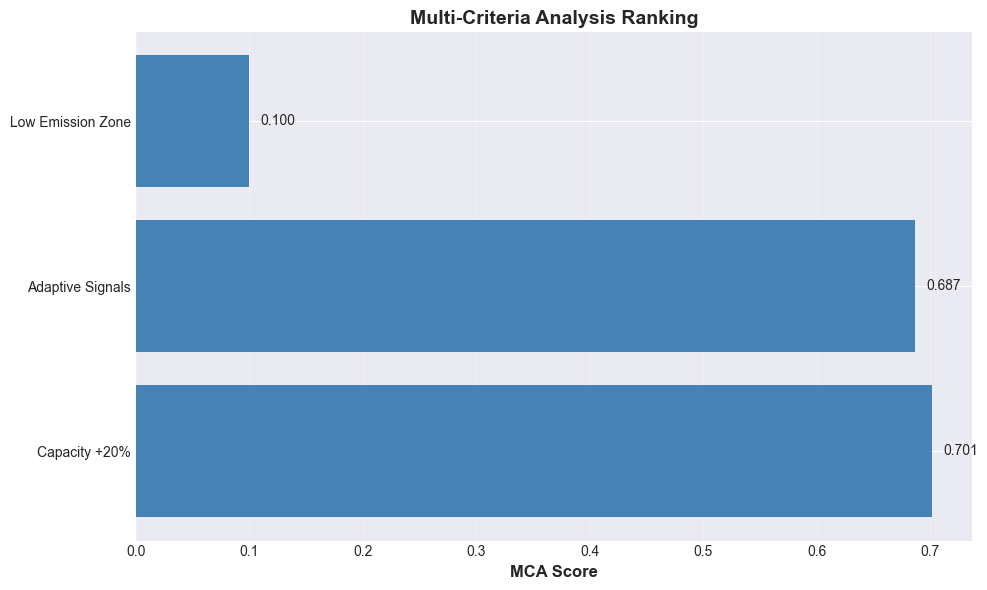

In [12]:
# Normalize criteria (min-max scaling)
def normalize_column(series: pd.Series) -> pd.Series:
    """Min-max normalization to [0, 1]."""
    span = series.max() - series.min()
    if span == 0:
        return pd.Series([1.0] * len(series), index=series.index)
    return (series - series.min()) / span

mca_df = cba_results.copy()
mca_df['NPV_norm'] = normalize_column(mca_df['NPV (€)'])
mca_df['BCR_norm'] = normalize_column(mca_df['BCR'])
mca_df['Time_norm'] = normalize_column(mca_df['Annual Time Savings (h)'])
mca_df['CO2_norm'] = normalize_column(mca_df['Annual CO2 Savings (t)'])

# Calculate weighted MCA score
mca_df['MCA Score'] = (
    mca_df['NPV_norm'] * MCA_WEIGHTS['npv'] +
    mca_df['BCR_norm'] * MCA_WEIGHTS['bcr'] +
    mca_df['Time_norm'] * MCA_WEIGHTS['time_savings'] +
    mca_df['CO2_norm'] * MCA_WEIGHTS['co2_reduction']
)

# Sort by MCA score
mca_df = mca_df.sort_values('MCA Score', ascending=False)

print("\n" + "=" * 70)
print("MULTI-CRITERIA ANALYSIS (MCA)")
print("=" * 70)
print(f"Weights: NPV={MCA_WEIGHTS['npv']:.0%}, BCR={MCA_WEIGHTS['bcr']:.0%}, "
      f"Time={MCA_WEIGHTS['time_savings']:.0%}, CO2={MCA_WEIGHTS['co2_reduction']:.0%}")
print()
print(mca_df[['Scenario', 'NPV (€)', 'BCR', 'MCA Score']].to_string(index=False))

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(mca_df['Scenario'], mca_df['MCA Score'], color='steelblue')
ax.set_xlabel('MCA Score', fontsize=12, fontweight='bold')
ax.set_title('Multi-Criteria Analysis Ranking', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

for i, (scenario, score) in enumerate(zip(mca_df['Scenario'], mca_df['MCA Score'])):
    ax.text(score + 0.01, i, f"{score:.3f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

## Part 4: Summary and Recommendations

In [13]:
print("\n" + "=" * 70)
print("SUMMARY AND RECOMMENDATIONS")
print("=" * 70)

# Best scenario by different criteria
best_npv = cba_results.loc[cba_results['NPV (€)'].idxmax(), 'Scenario']
best_bcr = cba_results.loc[cba_results['BCR'].idxmax(), 'Scenario']
best_mca = mca_df.iloc[0]['Scenario']

print(f"\nBest scenario by NPV: {best_npv}")
print(f"Best scenario by BCR: {best_bcr}")
print(f"Best scenario by MCA: {best_mca}")

print("\n" + "-" * 70)
print("KEY FINDINGS:")
print("-" * 70)

for _, row in cba_results.iterrows():
    print(f"\n{row['Scenario']}:")
    print(f"  NPV: €{row['NPV (€)']:,.0f}")
    print(f"  BCR: {row['BCR']:.2f}")
    print(f"  Annual time savings: {row['Annual Time Savings (h)']:,.0f} hours")
    print(f"  Annual CO2 reduction: {row['Annual CO2 Savings (t)']:,.0f} tonnes")

print("\n" + "=" * 70)


SUMMARY AND RECOMMENDATIONS

Best scenario by NPV: Capacity +20%
Best scenario by BCR: Adaptive Signals
Best scenario by MCA: Capacity +20%

----------------------------------------------------------------------
KEY FINDINGS:
----------------------------------------------------------------------

Capacity +20%:
  NPV: €1,374,273,621
  BCR: 196.25
  Annual time savings: 6,771,592 hours
  Annual CO2 reduction: 655 tonnes

Adaptive Signals:
  NPV: €852,472,784
  BCR: 577.18
  Annual time savings: 4,180,290 hours
  Annual CO2 reduction: 1,310 tonnes

Low Emission Zone:
  NPV: €2,603,319
  BCR: 1.64
  Annual time savings: 0 hours
  Annual CO2 reduction: 4,931 tonnes



## Save Results

In [14]:
# Create results directory
cba_results_dir = RESULTS_DIR / 'cba_mca'
cba_results_dir.mkdir(parents=True, exist_ok=True)

# Save tables
kpi_df.to_csv(cba_results_dir / 'scenario_kpis.csv', index=False)
cba_results.to_csv(cba_results_dir / 'cba_results.csv', index=False)
mca_df.to_csv(cba_results_dir / 'mca_results.csv', index=False)

# Save configuration
config = {
    'discount_rate': DISCOUNT_RATE,
    'evaluation_horizon': EVALUATION_HORIZON,
    'value_of_time': VALUE_OF_TIME,
    'co2_price': CO2_PRICE,
    'emission_factor_kg_per_km': EMISSION_FACTOR_KG_PER_KM,
    'avg_trip_length_km': AVG_TRIP_LENGTH_KM,
    'mca_weights': MCA_WEIGHTS,
    'scenarios': {
        'capacity': {
            'capex': CAPEX_CAPACITY,
            'opex': OPEX_CAPACITY,
            'capacity_increase': CAPACITY_INCREASE,
        },
        'signals': {
            'capex': CAPEX_SIGNALS,
            'opex': OPEX_SIGNALS,
            'delay_reduction': SIGNALS_DELAY_REDUCTION,
            'capacity_improvement': SIGNALS_CAPACITY_IMPROVEMENT,
        },
        'lez': {
            'capex': CAPEX_LEZ,
            'opex': OPEX_LEZ,
            'demand_reduction': LEZ_DEMAND_REDUCTION,
            'top_od_fraction': LEZ_TOP_OD_FRACTION,
            'emission_factor_multiplier': LEZ_EMISSION_REDUCTION_FACTOR,
        }
    }
}

with open(cba_results_dir / 'config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(f"Results saved to {cba_results_dir}")
print(f"  - scenario_kpis.csv")
print(f"  - cba_results.csv")
print(f"  - mca_results.csv")
print(f"  - config.json")

Results saved to ..\results\cba_mca
  - scenario_kpis.csv
  - cba_results.csv
  - mca_results.csv
  - config.json
